##**Social Media Data Extraction & Preprocessing (API Handling & Text Cleaning)**
**Google Summer of code Human AI Assessment..**

##Installing and Importing libraries

installing ...
The **emoji** library is a Python package used to add, interpret, and manipulate emojis in text. It supports both:

Shortcodes (e.g., :smile: → 😀)

Unicode emojis (e.g., 😎)


**Praw** A synchronous Reddit API wrapper

**asyncpraw**An asynchronous version of praw

**VADER (Valence Aware Dictionary and sEntiment Reasoner)** is a lexicon and rule-based sentiment analysis tool.It is specifically designed forSocial media text,Polarity classification,Intensity scoring



In [1]:
!pip install asyncpraw praw emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 36.4 MB/s eta 0:00:00


In [2]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.9 MB/s eta 0:00:00


##**Task 1**

In [3]:
import nest_asyncio
import asyncpraw, pandas as pd, re, emoji, nltk, asyncio
from nltk.corpus import stopwords
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

##**Using Reddit API**
Uses **praw** to extract Reddit posts by keyword..

you can create your own API Key using link[click here](https://www.reddit.com/prefs/apps)

In [4]:
nltk.download('stopwords')
nest_asyncio.apply()

# Reddit API Credentials
REDDIT_CLIENT_ID = "0dsKwNeeAtMUZmppuxxxx"
REDDIT_CLIENT_SECRET = "wZRN9A-DfdLWZWNOXlqbr6zljHxxxx"
REDDIT_USER_AGENT = "MyScript/1.0 (by u/Glittering-Spread293)"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
KEYWORDS  = ["depressed", "addiction help", "overwhelmed", "suicidal",
            "anxious", "panic attack", "lonely", "mental health",
            "self-harm", "substance abuse", "hopeless", "despair" , "trauma", "Drugs" , "betrayal"]

In [6]:
HIGH_RISK_TERMS = [
    "suicide", "kill myself", "end it", "no reason to live",
    "not want to live", "take my life", "self-harm", "cutting",
    "bleeding out", "end everything", "give up", "final goodbye",
    "no point in living", "hopeless", "jump off", "overdose",
    "goodbye forever", "won’t be here tomorrow", "can't take it anymore",
    "permanent solution", "last day", "ready to die", "slit my wrists",
    "die alone", "better off dead", "can’t go on"
]


MODERATE_RISK_TERMS = [
    "depressed", "lonely", "struggle", "lost", "can't cope",
    "feeling empty", "overwhelmed", "isolated", "numb",
    "sadness", "worthless", "nothing matters", "anxious",
    "scared", "no motivation", "crying", "panic",
    "drowning", "broken", "mentally exhausted", "shaking",
    "helpless", "fearful", "low self-worth", "hopelessness",
    "burnout", "emotional pain", "stuck in my head", "drained",
    "distant", "fading away"
]


##Data Preprocessing and Cleaning

Collects Post ID, Timestamp, Content, Likes, Comments, and Shares.

**Data Cleaning** Removes emojis using the emoji library.

Cleans URLs and special characters.

Removes stopwords using nltk.

In [7]:
async def init_reddit():
    return asyncpraw.Reddit(client_id=REDDIT_CLIENT_ID,
                            client_secret=REDDIT_CLIENT_SECRET,
                            user_agent=REDDIT_USER_AGENT)

In [8]:
async def extract_reddit(api, keywords):
    data = []
    subreddit = await api.subreddit("all")

    for keyword in keywords:
        async for post in subreddit.search(keyword, limit=50):
            data.append({
                "ID": post.id,
                "Time": post.created_utc,
                "Text": post.selftext or post.title,
                "Likes": post.score,
                "Comments": post.num_comments,
                "Shares": 0
            })
    return pd.DataFrame(data)

In [9]:
def clean_text(text):
    text = emoji.replace_emoji(text, replace='')  # Remove emojis
    text = re.sub(r"http\S+|[^A-Za-z0-9\s]", '', text)  # Clean URLs & special chars
    return " ".join(w for w in text.lower().split() if w not in stopwords.words('english'))

#**Sentiment Classification**
#task 2
>Use VADER for accurate sentiment classification on short texts.

> Use TextBlob as a backup for longer posts.

>Sentiment Classification

Uses VADER (more accurate for short texts).

Falls back on TextBlob for neutral cases.

Classifies posts as:

1. Positive → VADER compound ≥ 0.05

2. Negative → VADER compound ≤ -0.05

3. Neutral → Uses TextBlob as backup

>**TF-IDF & Risk Level Detection**

TF-IDF Vectorizer → Detects the presence of high-risk terms.

Risk Categories:

1. High-Risk → Direct crisis language.

2. Moderate Concern → Seeking help or struggling.

3. Low Concern → General discussions.








In [10]:
def classify_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vader_score = analyzer.polarity_scores(text)

    if vader_score['compound'] >= 0.05:
        return "Positive"
    elif vader_score['compound'] <= -0.05:
        return "Negative"
    else:
        # Use TextBlob as backup for neutral cases
        blob_score = TextBlob(text).sentiment.polarity
        if blob_score > 0:
            return "Positive"
        elif blob_score < 0:
            return "Negative"
        else:
            return "Neutral"

# TF-idf
def detect_risk_level(text, vectorizer, tfidf_matrix):
    crisis_score = sum(tfidf_matrix.toarray()[0])

    if any(term in text for term in HIGH_RISK_TERMS):
        return "High-Risk"
    elif any(term in text for term in MODERATE_RISK_TERMS):
        return "Moderate Concern"
    else:
        return "Low Concern"

Reddit data with sentiment and risk level save to csv


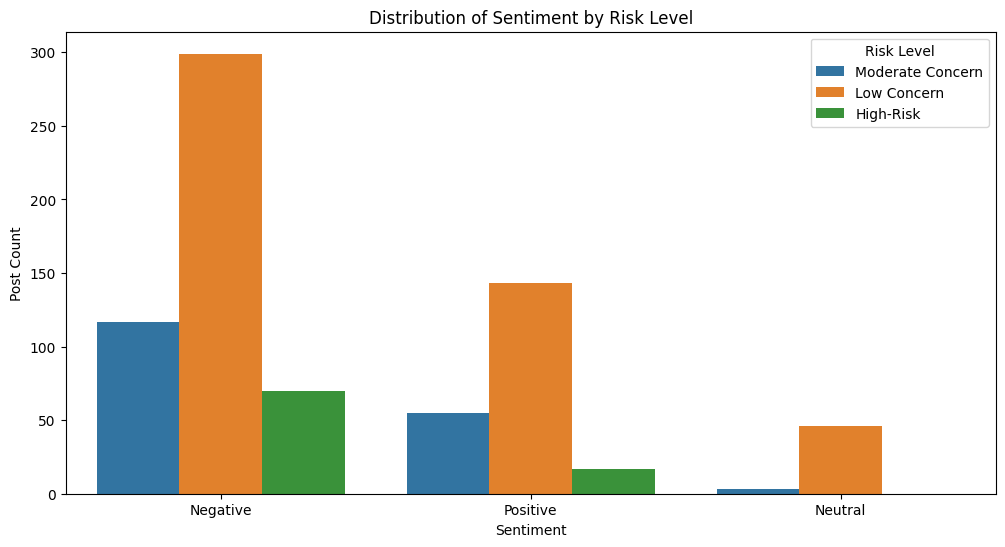

In [11]:
async def main():
    reddit = await init_reddit()
    data = await extract_reddit(reddit, KEYWORDS)
    data['Text'] = data['Text'].apply(clean_text)

    # Apply Sentiment Classification
    data['Sentiment'] = data['Text'].apply(classify_sentiment)

    # TF-IDF
    vectorizer = TfidfVectorizer(vocabulary=HIGH_RISK_TERMS + MODERATE_RISK_TERMS)

    risk_levels = []
    for post in data['Text']:
        tfidf_matrix = vectorizer.fit_transform([post])
        risk_levels.append(detect_risk_level(post, vectorizer, tfidf_matrix))

    data['Risk_Level'] = risk_levels # column name is Risk_Level
    data.to_csv("reddit_sentiment_risk_data.csv", index=False)
    print("Reddit data with sentiment and risk level save to csv")

    # Plot
    plt.figure(figsize=(12, 6))
    sns.countplot(x="Sentiment", hue="Risk_Level", data=data) # Changed to Risk_Level
    plt.title("Distribution of Sentiment by Risk Level")
    plt.xlabel("Sentiment")
    plt.ylabel("Post Count")
    plt.legend(title="Risk Level")
    plt.show()
await main()

In [12]:
pd.read_csv("/content/reddit_sentiment_risk_data.csv").head(10)

,ID,Time,Text,Likes,Comments,Shares,Sentiment,Risk_Level
0,d2uw3s,1.568228e+09,whats subtle sign someones depressed,34881,6206,0,Negative,Moderate Concern
1,mdj4aq,1.616743e+09,might stupid question like depressed,12438,2398,0,Negative,Moderate Concern
2,9pt9rz,1.540033e+09,depression looks like,133366,4870,0,Negative,Low Concern
3,wuw6mp,1.661181e+09,people living depression kind mood disorder de...,10592,2835,0,Negative,Moderate Concern
4,16obo8c,1.695290e+09,example fact want productive healthy things so...,371,370,0,Positive,Low Concern
5,1jan64x,1.741901e+09,owner depression cleaned home free,102690,2062,0,Negative,Low Concern
6,1i72ra2,1.737519e+09,seriously cant stop crying happening country t...,28822,6155,0,Negative,Moderate Concern
7,1izedw6,1.740659e+09,movie depressing ending,10326,4714,0,Negative,Low Concern
8,1gs77xi,1.731706e+09,thanks adhd depression cured,31250,7751,0,Negative,Low Concern
9,1iqbncz,1.739654e+09,lot ups downs years finally took past year foc...,32961,774,0,Positive,Low Concern


##**Crisis Geolocation & Mapping**

#**Task 3**

#**Steps**

1. Location Extraction that Extracts location names from Reddit posts using NLP-based recognition.

2. Geocoding , i Use OpenCage API to convert location names into latitude and longitude coordinates.

3. Fixing List-to-String Issue , Converts lists to strings for proper dictionary lookup.

4. Generates a heatmap of crisis-related posts using Folium.

5. Top 5 Crisis Locations that  Displays the locations with the highest mentions.



In [13]:
!pip install folium plotly geopy  textblob nest_asyncio


#using Opencage API for Geocoding
get your opencage API key [click here](https://opencagedata.com/)


In [14]:
!pip install opencage
import pandas as pd
from opencage.geocoder import OpenCageGeocode
from collections import Counter
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import time


In [15]:
data = pd.read_csv("/content/reddit_sentiment_risk_data.csv")

#Location extration using Regex pattern

extract_location updated to location

Visualize the geolocation data using Folium.

In [16]:
data['Text'] = data['Text'].fillna("").astype(str)

LOCATION_PATTERNS = [
    r'\b(?:new york|los angeles|texas|california|florida|chicago|san francisco|miami|seattle|boston|atlanta|austin|denver|houston)\b',
    r'\b(?:canada|toronto|vancouver|ottawa|montreal)\b',
    r'\b(?:london|paris|berlin|madrid|rome)\b',
    r'\b(?:india|delhi|mumbai|bangalore|hyderabad|kolkata|chennai)\b',
]

def extract_location(text):
    """Extract location from text based on patterns"""
    for pattern in LOCATION_PATTERNS:
        match = re.findall(pattern, text, flags=re.IGNORECASE)
        if match:
            return ', '.join(match)
    return "Unknown"
data['Location'] = data['Text'].apply(extract_location)


In [17]:
API_KEY = "c7e75c07ff164c97b0a999cfbc9xxxx"  # opencage api
geocoder = OpenCageGeocode(API_KEY)

Caching ensures that locations already geocoded are not repeatedly sent to the OpenCage API, saving both:

API requests (preventing redundant calls).

Execution time (faster processing by reusing previous results).



In [18]:
geo_cache = {}

def geocode_location(location, max_retries=3):
    if location in geo_cache:
        return geo_cache[location]

    for attempt in range(max_retries):
        try:
            results = geocoder.geocode(location)
            if results:
                lat = results[0]['geometry']['lat']
                lon = results[0]['geometry']['lng']
                geo_cache[location] = (lat, lon)
                print(f"Geocoded: {location} → {lat}, {lon}")
                return lat, lon
            else:
                print(f"No geolocation results for: {location}")
                geo_cache[location] = (None, None)
                return None, None
        except Exception as e:
            print(f"Error geocoding {location} (Attempt {attempt + 1}): {e}")
            time.sleep(1)

    print(f"Failed to geocode: {location}")
    geo_cache[location] = (None, None)
    return None, None

In [19]:
latitudes, longitudes = [], []

for loc in data['Location'].explode().unique():
    if loc != "Unknown":
        lat, lon = geocode_location(loc)
        latitudes.append(lat)
        longitudes.append(lon)
    else:
        latitudes.append(None)
        longitudes.append(None)

# Map geolocation data back to the dataset
data['Latitude'] = data['Location'].apply(lambda loc: geo_cache.get(loc, (None, None))[0])
data['Longitude'] = data['Location'].apply(lambda loc: geo_cache.get(loc, (None, None))[1])

# Save the geocoded data
data.to_csv("reddit_geolocation_data_opencage.csv", index=False)
print("Data saved reddit_geolocation_data_opencage.csv")


Geocoded: florida, florida, florida, florida → 27.25, -81.25
Geocoded: austin, texas → 30.2711286, -97.7436995
Geocoded: new york → 40.7127281, -74.0060152
Geocoded: florida → 27.7567667, -81.4639835
Geocoded: seattle → 47.6038321, -122.330062
Geocoded: texas → 31.2638905, -98.5456116
Geocoded: california → 36.7014631, -118.755997
Geocoded: texas, texas → 32.7563057, -97.0713679
Geocoded: houston → 29.7589382, -95.3676974
Geocoded: paris → 48.8534951, 2.3483915
Geocoded: canada → 61.0666922, -107.991707
Geocoded: miami → 25.7741728, -80.19362
Data saved reddit_geolocation_data_opencage.csv


##Mapping


21 posts with valid geolocation data out of 750 total posts.
Failed to geocode 729 locations.

Top 5 Crisis Locations:
Unknown: 729 mentions
florida: 4 mentions
seattle: 3 mentions
canada: 3 mentions
california: 2 mentions


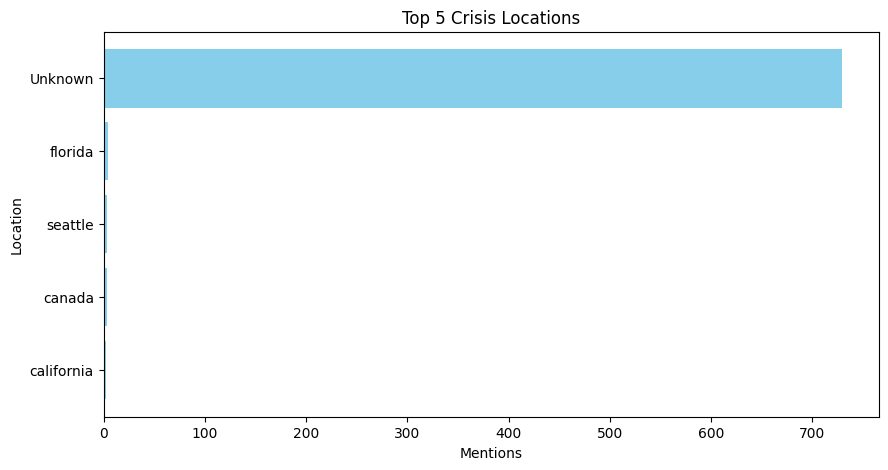

In [23]:
valid_data = data.dropna(subset=['Latitude', 'Longitude'])

print(f"{len(valid_data)} posts with valid geolocation data out of {len(data)} total posts.")
print(f"Failed to geocode {len(data) - len(valid_data)} locations.")

location_count = Counter(data['Location'].explode())
top_locations = location_count.most_common(5)


print("\nTop 5 Crisis Locations:")
for loc, count in top_locations:
    print(f"{loc}: {count} mentions")

# Plotting top locations
plt.figure(figsize=(10, 5))
top_locs, top_counts = zip(*top_locations)
plt.barh(top_locs, top_counts, color='skyblue')
plt.xlabel("Mentions")
plt.ylabel("Location")
plt.title("Top 5 Crisis Locations")
plt.gca().invert_yaxis()
plt.show()


**Top 5 Crisis Locations:**

Unknown: 729 mentions

florida: 4 mentions

seattle: 3 mentions

canada: 3 mentions

california: 2 mentions



##HeatMap

View heatmap [Click here](file:///C:/Users/shubh/Downloads/crisis_heatmap_opencage.html)

In [24]:
def generate_heatmap(df, output_file="crisis_heatmap_opencage.html"):
    if df.empty:
        print("No valid geolocation data available for heatmap.")
        return
    map_center = [39.8283, -98.5795]
    heatmap = folium.Map(location=map_center, zoom_start=4)
    # Extract latitude and longitude data
    heat_data = df[['Latitude', 'Longitude']].dropna().values.tolist()
    # Add heatmap layer
    HeatMap(heat_data).add_to(heatmap)
    # Save the heatmap to an HTML file
    heatmap.save(output_file)
    print(f"Heatmap saved as {output_file}")
generate_heatmap(valid_data)

Heatmap saved as crisis_heatmap_opencage.html


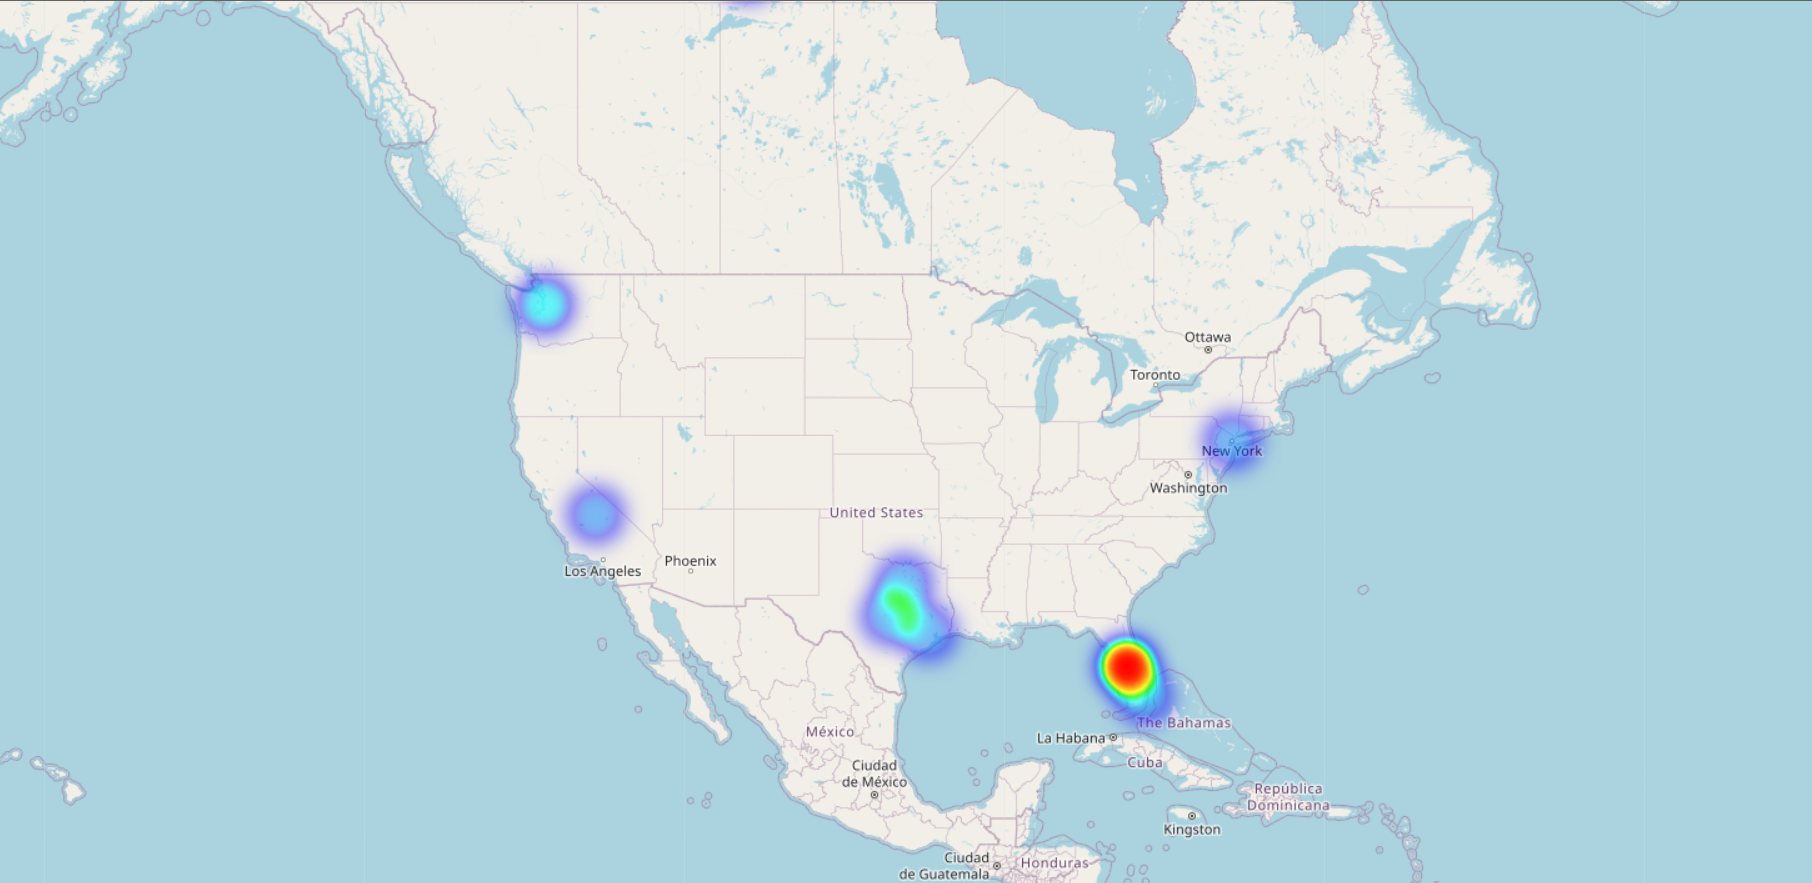

#visualization of regional distress patterns

preprocessing.
1. Filters the dataset to only include rows with valid latitude and longitude values.

2. Fills missing locations with 'Unknown' to prevent errors during plotting.


Uses Seaborn's countplot() to visualize the Sentiment distribution by region.

Hue groups the bars by sentiment (Positive, Neutral, Negative).


<ipython-input-22-ea4cefdf1fa6>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mentions', y='Region', data=region_counts.head(15), palette='Reds')
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7fcdf5225350>
ERROR:asyncio:Unclosed connector
connections: ['deque([(<aiohttp.client_proto.ResponseHandler object at 0x7fcdaa81fbd0>, 406.809683373)])']
connector: <aiohttp.connector.TCPConnector object at 0x7fcdab202c10>


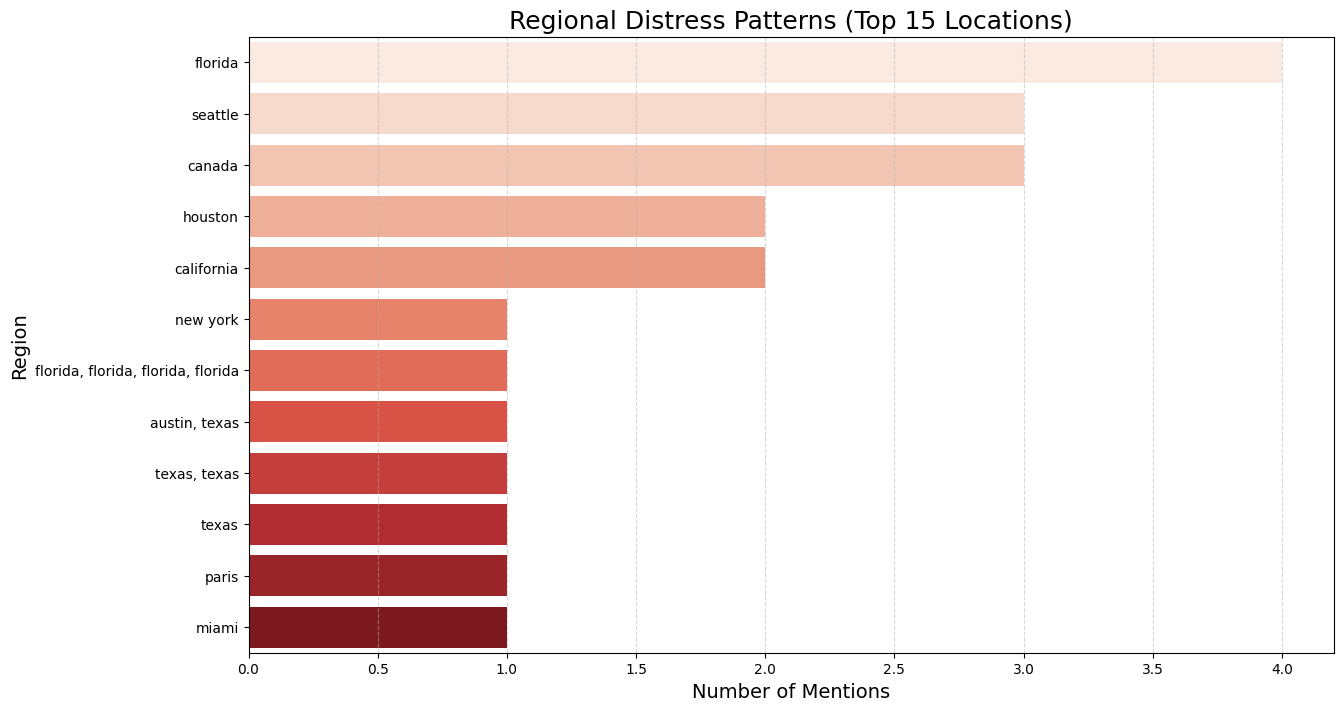

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

valid_locations = data[data['Location'] != 'Unknown']
region_counts = valid_locations['Location'].value_counts().reset_index()
region_counts.columns = ['Region', 'Mentions']

plt.figure(figsize=(14, 8))
sns.barplot(x='Mentions', y='Region', data=region_counts.head(15), palette='Reds')

plt.title('Regional Distress Patterns (Top 15 Locations)', fontsize=18)
plt.xlabel('Number of Mentions', fontsize=14)
plt.ylabel('Region', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()
